In [12]:
from __future__ import absolute_import, division, print_function
from matplotlib.font_manager import _rebuild; _rebuild()
import tensorflow as tf

#Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas
import scipy.io as spio
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

tf.logging.set_verbosity(tf.logging.INFO)

In [13]:
"""Load the dataset and set randomness."""

# Initialize random number generator for reproducibility.
seed = 7
np.random.seed(seed)

# Load in dataset.
data = spio.loadmat("features_10s_2019-01-30.mat");
features = data['features'];
labels = data['labels_features'];
animal_id_features = data['animal_id_features'];

# Flatten animal IDs so we can slice by animal.
id_features = np.ravel(animal_id_features);

# Count number of features per animal label.
features_per_animal = np.bincount(id_features);

# Get only features corresponding to first animal.
fKH41_num_samples = features_per_animal[1];
fKH41_features = features[1:fKH41_num_samples];

# Get only labels corresponding to first animal's features.
fKH41_labels = labels[:,1:fKH41_num_samples];
fKH41_labels = fKH41_labels.transpose();

In [14]:
"""Split data into training and testing for cross-validation."""
data_train, data_test, labels_train, labels_test = train_test_split(fKH41_features, fKH41_labels, test_size=0.20, random_state=seed);

In [15]:
"""Define the neural network model with 141 inputs, x hidden nodes, 
and 3 outputs (pre-ictal, inter-ictal, normal)."""
def nn_model():
    # Create model.
    model = Sequential()
    model.add(Dense(8,input_dim=141,activation='relu'))
    model.add(Dense(units=3,activation='softmax'))
    # Compile model.
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
    return model

NN Args: Batch Size: 500, Steps/Epoch: 154
All Data in History: dict_keys(['loss', 'acc'])


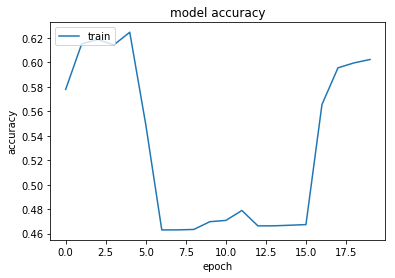

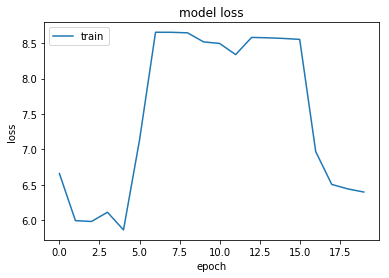

In [20]:
"""Create KerasClassifier and pass args to the fit function used internally to train the NN."""
# Set batch size, steps per epoch.
training_set_size = data_train.shape[0];
batch_size = 500;
steps_per_epoch = (training_set_size // batch_size)
print("NN Args: Batch Size: {}, Steps/Epoch: {}".format(batch_size, steps_per_epoch));

# Compile the model and record history.
estimator = KerasClassifier(build_fn=nn_model,epochs=20,batch_size=batch_size,verbose=0)
history = estimator.fit(data_train,labels_train,verbose=0)
# print("All Data in History: {}".format(history.history.keys()))

# Summarize history for accuracy.
plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Summarize history for loss.
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [21]:
"""Evaluate the model with cross-validation for single animal."""

kfold = KFold(n_splits=2, shuffle=True, random_state=seed)
results = cross_val_score(estimator, data_train, labels_train, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 46.40% (0.28%)
